In [389]:
%matplotlib widget
import warnings
import inspect
import matplotlib.pyplot as plt
import IPython.display
import numpy as np
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
from cued_sf2_lab.dct import colxfm
from cued_sf2_lab.laplacian_pyramid import quantise,bpp
from cued_sf2_lab.dct import regroup


# 8 The Lapped Bi-orthogonal Transform (LBT)

<!-- sorry for the nasty HTML, markdown is bad for figures -->

<figure style="text-align: center">
<div class="row">
<figure class="col-md-4 col-md-offset-1">
<img src="figures/lbt.png" style="max-height: 350px" />
<figcaption>(a) Lapped Bi-orthogonal Transform</figcaption>
</figure>

<figure class="col-md-5 col-md-offset-1">
<img src="figures/pot.png" style="max-height: 350px" />
<figcaption>(b) Photo Overlap Transform and a DCT</figcaption>
</figure>
</div>
<div class="row">
<figcaption>
<br />

Figure 4: (a) An LBT transforms overlapping sections of `X` to create `Y`. (b) In some cases
this can be interpreted as pre-filtering with a POT, followed by a DCT.</figcaption></div></figure>

One of the difficulties with the DCT is that it processes each block separately and hence
does not take advantage of any correlation between blocks. A possible solution to this is
to use a _Lapped Bi-orthogonal Transform (LBT)_. These transform overlapping blocks in `X`
to generate smaller non-overlapping blocks in `Y`. In the left-hand figure above, 16 values
in `X` are used to generate each set of 8 values in `Y`.

LBTs are quite complicated to derive and analyse: however one of the most popular forms<sup>3</sup>
can also be represented as a pre-filtering operation before performing the DCT described
in the previous section.
In this case the pre-filtering (or post-filtering for the reverse
operation) is sometimes known as a _Photo Overlap Transform or POT_. A POT followed
by a DCT is then equivalent to a particular type of LBT.

The right-hand figure above demonstrates this. The POT is first performed on a section
of data `X`, shifted by `N/2`, so that it runs across the block boundaries of the subsequent
DCT. Ignoring this block shift for a moment, the forward operation for a 2D image `X` is:


$$Y = C ∗ Pf ∗ X ∗ Pf ′ ∗ C′$$

or in reverse

$$ X = Pr′ ∗ C′ ∗ Y ∗ C ∗ Pr $$

<hr />
<small><sup>3</sup>The type-II fast lapped (bi-)orthogonal transform, or LOT-II</small>

## 8.1 Applying the LBT to images

In [390]:
X, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
X = X - 128.0

The pre-filtering `Pf ∗ X ∗ Pf′` (with the correct block shift) is straightforward in Python:

```python
t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
Xp = X.copy()  # copy the non-transformed edges directly from X
Xp[t,:] = colxfm(Xp[t,:], Pf)
Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
```

This is followed by the DCT `C` as before. In the reverse operation, the inverse DCT `C’` is
performed first, followed by Pr’:
```python
Zp = Z.copy()  #copy the non-transformed edges directly from Z
Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
Zp[t,:] = colxfm(Zp[t,:], Pr.T)
```

We have provided a function `pot_ii(N, s)` which will generate a forward (pre-filtering,
`Pf`) and reverse (post-filtering, `Pr`) matrix of size `N` with scaling factor `s`.

In [391]:
from cued_sf2_lab.lbt import pot_ii, dct_ii


In [392]:
import inspect
import IPython.display
IPython.display.Code(inspect.getsource(pot_ii), language="python")

def pot_ii(N, s=(1+(5**0.5))/2, overlap=None):
    """
    Generates the 1-D POT transform matrices of size N

    Equivalent to the pre-filtering stage of a Type-II fast
    Lapped Orthogonal Transform (LOT-II).

    POT_II Photo Overlap Transform matrix

    Y = Pf * X pre-filters N-vector X into Y.
    X = Pr' * Y post-filters N-vector Y into X.

    Parameters:
    N (int): Size of DCT used
    s (float): Scaling factor determining the orthogonality of the transform.
    s=1 generates a LOT (Pr = Pf), otherwise 1<s<2 generates
    an LBT. The default is the Golden Ratio, (1+5^0.5)/2.
    overlap (int): Determines amount of overlap. 0<overlap<=N/2.
    Default is N/2, which implies complete overlap with the corresponding DCT

    Returns:
    Pf (np.ndarray): Prefiltering matrix
    Pr (np.ndarray): Postfiltering matrix

    """
    # ensure N is divisible 2 and is an integer
    if N % 2 != 0 or type(N) != int:
        raise ValueError('N must be an integer divisible by 2.')
    if overlap is None:
        # produces an integer which survives next test
        overlap = N//2
    else:
        try:
            overlap = operator.index(overlap)
        except TypeError as e:
            raise TypeError('overlap must be an integer') from e
    # TODO: Ask Joan whether the lower limit is 0 or 1. She said 0 for now.
    if overlap > N/2 or overlap < 0:
        raise ValueError('overlap must satisfy 0<overlap<=N/2')
    # generate identity matrix
    Id = np.identity(N//2)
    # print('I', Id)
    # flip identity in the left/right direction
    J = np.fliplr(Id)

    Z = np.zeros((N//2, N//2))
    C_ii = dct_ii(overlap)
    # print('C_ii', C_ii)
    C_iv = dct_iv(overlap)
    # print('C_iv', C_iv)

    # generate forward and reverse scaling matrices
    # use a list to be able to concatenate
    diag_ones = [1 for i in range(overlap-1)]
    Sf = np.diag([s]+diag_ones)
    Sr = np.diag([1/s]+diag_ones)

    # generate forward and reverse filtering matrices
    if overlap < N/2:
        VI = np.identity((N//2)-overlap)
        VJ = np.fliplr(VI)
        VZ = np.zeros((overlap, (N//2)-overlap))
        Vf = np.block([
            [VJ @ C_ii.T @ Sf @ C_iv @ VJ, VZ],
            [VZ.T, VI]])
        # for Vr
        Vr = np.block([
            [VJ @ C_ii.T @ Sr @ C_iv @ VJ, VZ],
            [VZ.T, VI]])

    else:
        Vf = J @ C_ii.T @ Sf @ C_iv @ J
        Vr = J @ C_ii.T @ Sr @ C_iv @ J
    # create component matrices to build Pf and Pr
    mtrx_1 = np.block([[Id, J], [J, -Id]])
    pf_1 = np.block([[Id, Z], [Z, Vf]])
    pr_1 = np.block([[Id, Z], [Z, Vr]])

    Pf = 0.5*(mtrx_1 @ pf_1 @ mtrx_1)
    Pr = 0.5*(mtrx_1 @ pr_1 @ mtrx_1)
    return Pf, Pr

Edit your code
for performing DCT analysis so that it can pre-filter `X` with `Pf` before the forward DCT,
then post-filter `Z` with `Pr` after the inverse DCT. Confirm that, without quantisation, this
correctly recreates the original image, i.e. `Zp = X`. Use `Pf, Pr = pot_ii(N)` with the
default scaling value `s`.

RMS error: 0.000000


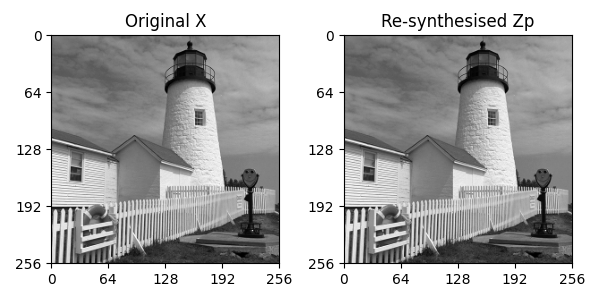

In [393]:
# your code here
# 1.  get POT and DCT matrices
# -------------------------------------------------------------
N  = 8                                      # block size
Pf, Pr = pot_ii(N)                          # default scale s = 1.4
C      = dct_ii(N)                          # orthonormal DCT-II

# 2.  FORWARD  :  X  -->  Y   (Pf  +  DCT)
t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
Xp = X.copy()  # copy the non-transformed edges directly from X
Xp[t,:] = colxfm(Xp[t,:], Pf)
Xp[:,t] = colxfm(Xp[:,t].T, Pf).T

Y  = colxfm(colxfm(Xp.T, C).T, C)           # 2-D block DCT

# 3.  REVERSE  :  Y  -->  Zp  (inverse DCT  +  Pr)
Z = colxfm(colxfm(Y.T, C.T).T, C.T)    #without quantisation

Zp = Z.copy()  #copy the non-transformed edges directly from Z
Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
Zp[t,:] = colxfm(Zp[t,:], Pr.T)

# 4.  confirm perfect reconstruction
# -------------------------------------------------------------
rms = np.std(X - Zp)
print(f"RMS error: {rms:.6f}")

# quick visual check
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))
plot_image(X,  ax=ax1); ax1.set_title("Original X")
plot_image(Zp,  ax=ax2); ax2.set_title("Re-synthesised Zp")
plt.tight_layout(); plt.show()

## 8.2 Quantisation and coding efficiency

The scaling factor `s` determines the degree of bi-orthogonality. If `s = 1` then Pf is the same
as Pr, otherwise `1 < s < 2` weights the relative contributions of `Pf` and `Pr` un-equally.

<div class="alert alert-block alert-danger">

For an 8 × 8 DCT, try implementing an LBT with POT scaling factors varying from $1$
to $2$ ($\sqrt{2}$ is often a good choice). In each case find the quantisation step which makes
the rms error match the directly quantised image. Note the compression ratios and find
the scaling factor which maximises these. Also note the visual features in these images.</div>

In [394]:
# your code here
def lbt_reconstruct(X, N, s, step):
    """
    Apply a POT+block-DCT analysis/synthesis to image X and return Zp.

    Parameters
    ----------
    X    : 2-D ndarray
           Spatial image (zero-mean if you previously subtracted 128).
    N    : int
           Block size of the DCT (default 8).
    s    : float
           Overlap (scale) parameter for the POT (default 1.4).
    step : float or None
           If given, quantise the DCT coefficients with this step
           before the inverse transform.  If None, no quantisation.

    Returns
    -------
    Zp : 2-D ndarray
         Reconstructed image after inverse DCT and post-filter.
    """
    # ----- 1.  matrices -------------------------------------------------
    Pf, Pr = pot_ii(N, s)         # forward & reverse POT filters
    C      = dct_ii(N)            # orthonormal block DCT

    # slice that selects interior rows/cols (overlapped region)
    t = np.s_[N//2 : -N//2]

    # ----- 2.  forward POT ---------------------------------------------
    Xp = X.copy()
    Xp[t, :] = colxfm(Xp[t, :],  Pf)       # columns
    Xp[:, t] = colxfm(Xp[:, t].T, Pf).T    # rows

    # ----- 3.  block DCT ------------------------------------------------
    Y = colxfm(colxfm(Xp.T, C).T, C)

    # optional quantisation
    
    Y = quantise(Y, step)

    # ----- 4.  inverse DCT ---------------------------------------------
    Z = colxfm(colxfm(Y.T, C.T).T, C.T)

    # ----- 5.  post-filter ---------------------------------------------
    Zp = Z.copy()
    Zp[:, t] = colxfm(Zp[:, t].T, Pr.T).T  # rows
    Zp[t, :] = colxfm(Zp[t, :],  Pr.T)     # columns

    return Zp

In [395]:
# your code here

#with N=8 and s = root 2
#durectly quantised
Xq = quantise(X, step=17)
rms_err_Xq = np.std(X- Xq)
print(f'rms error between X and Xq is {rms_err_Xq:.5}')

#LBT
def rms_LBT(step:float, s:float,N: int) -> float:
    """Return RMS error for an N×N LBT with overlap-parameter *s*
       when the DCT coefficients are quantised with step Δ=*step*."""
    
    Zp = lbt_reconstruct(X, N, s, step)
    rms_err_Zp = np.std(X- Zp)
    return rms_err_Zp

rms_err_Zp = rms_LBT(step=17,s=np.sqrt(2),N=8)
print(f'rms error between X and Zp is {rms_err_Zp:.5}')



rms error between X and Xq is 4.8612
rms error between X and Zp is 3.528


In [396]:
# optimise the step
target_err = rms_err_Xq                                
def find_step_LBT(target_err: float,
                  s: float,
                  N: int,
                  lo: float = 1.0,
                  hi: float = 50.0,
                  tol: float = 1e-3,
                  max_iter: int = 5000):
    """Binary-search Δ so that rms_LBt(step) ≈ target_err."""    
    for _ in range(max_iter):          # failsafe upper bound
        mid = 0.5 * (lo + hi)
        e   = rms_LBT(mid,s, N)

        # stop if we're close enough
        if abs(e - target_err) <= tol:
            return mid, e

        # otherwise shrink the half-interval that gives too much error
        if e > target_err:
            hi = mid          # error too big, we need a smaller step
        if e < target_err:
            lo = mid          # error too small ⇒ we need a larger step

    # If we drop out because of max_iter, return the best we have
    return mid, e   #mid is the matched step size, e is the error

# optimise step size
opt_step, opt_error = find_step_LBT(target_err=4.8612, s=np.sqrt(2),N=8)
print(f"\nmatched step ≈ {opt_step:.3f}  →  RMS = {opt_error:.3f}")


matched step ≈ 25.955  →  RMS = 4.862


In [397]:
for s in (1, 1.2, 1.4, 1.6, 1.7, 1.8, 1.9, 2.0):
    opt_step, opt_error = find_step_LBT(target_err=4.8612, s=s, N=8)
    print(f"s = {s:3.1f}  →  matched Δ ≈ {opt_step:.3f}")


s = 1.0  →  matched Δ ≈ 23.371
s = 1.2  →  matched Δ ≈ 24.854
s = 1.4  →  matched Δ ≈ 25.883
s = 1.6  →  matched Δ ≈ 26.397
s = 1.7  →  matched Δ ≈ 26.469
s = 1.8  →  matched Δ ≈ 26.547
s = 1.9  →  matched Δ ≈ 26.535
s = 2.0  →  matched Δ ≈ 26.445


In [398]:
# reference bits and rms for direct pixel-domain quantisation (Δ = 17)
from cued_sf2_lab.dct import regroup
def dctbpp(Yr: np.ndarray, N: int) -> int:
    """
    Return the total number of bits required to code the regrouped DCT image Yr.

    Parameters
    ----------
    Yr : 2-D ndarray
        Regrouped DCT coefficients (size 256×256 for an 8×8 block image).
    N  : int
        DCT block size (8 for an 8×8 transform).

    Returns
    -------
    total_bits : int
        Sum over all N×N coefficient sub-images of  bits_per_pixel * pixels_in_subimage.
    """
    blk = Yr.shape[0] // N          # tile size, 256/8 = 32
    total_bits = 0

    for v in range(N):              # vertical frequency index
        for h in range(N):          # horizontal frequency index
            Ys = Yr[v*blk:(v+1)*blk, h*blk:(h+1)*blk]   # 32×32 tile
            total_bits += bpp(Ys) * Ys.size             # entropy × pixels

    return total_bits

step_ref = 17
Xq       = quantise(X, step_ref)
bits_ref = bpp(Xq) * Xq.size
rms_ref  = np.std(X - Xq)

print(f"Reference bits : {bits_ref:,.0f}  (Δ={step_ref}) RMS={rms_ref:.3f}\n")

N        = 8                      # block size
C        = dct_ii(N)              # DCT matrix
t_slice  = lambda N: np.s_[N//2:-N//2]

for s in (1.0, 1.2, 1.4, np.sqrt(2), 1.6, 1.8, 2.0):

    # 1. find Δ* that gives rms_ref for this s
    Δ_star, _ = find_step_LBT(rms_ref, s=s, N=N)

    # 2. forward LBT ----------------------------------------------------
    t         = t_slice(N)
    Pf, Pr    = pot_ii(N, s)
    Xp        = X.copy()
    Xp[t, :]  = colxfm(Xp[t, :],  Pf)
    Xp[:, t]  = colxfm(Xp[:, t].T, Pf).T
    Y         = colxfm(colxfm(Xp.T, C).T, C)

    # 3. quantise and regroup ------------------------------------------
    Yq   = quantise(Y, Δ_star)
    Yr   = regroup(Yq, N) / N
    bits = dctbpp(Yr, N)

    # 4. compression ratio ---------------------------------------------
    CR   = bits_ref / bits
    print(f"s={s:4.2f}  optimised_step={Δ_star:6.3f}  bits={bits:9,.0f}  CR={CR:5.2f}")


Reference bits : 228,119  (Δ=17) RMS=4.861

s=1.00  optimised_step=23.371  bits=   75,548  CR= 3.02
s=1.20  optimised_step=24.854  bits=   73,233  CR= 3.11
s=1.40  optimised_step=25.883  bits=   72,783  CR= 3.13
s=1.41  optimised_step=25.955  bits=   72,763  CR= 3.14
s=1.60  optimised_step=26.397  bits=   73,934  CR= 3.09
s=1.80  optimised_step=26.547  bits=   76,424  CR= 2.98
s=2.00  optimised_step=26.445  bits=   79,797  CR= 2.86


23.37060546875 4.86132596533352


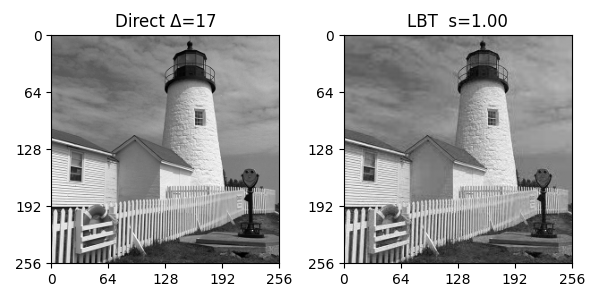

24.85400390625 4.860220214147087


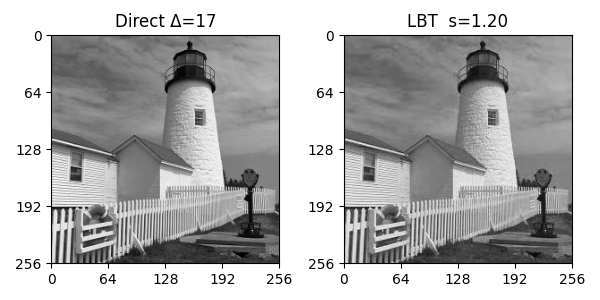

25.8828125 4.860971530390814


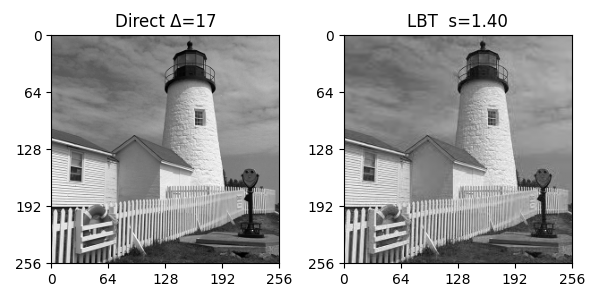

25.95458984375 4.861785889658821


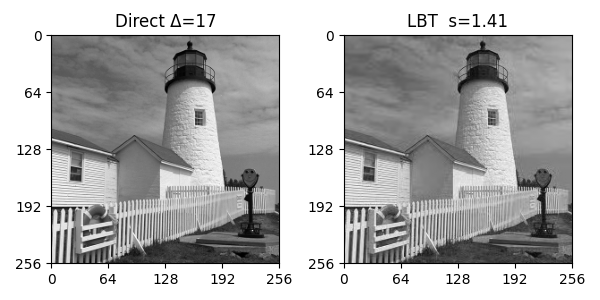

26.397216796875 4.861301010980739


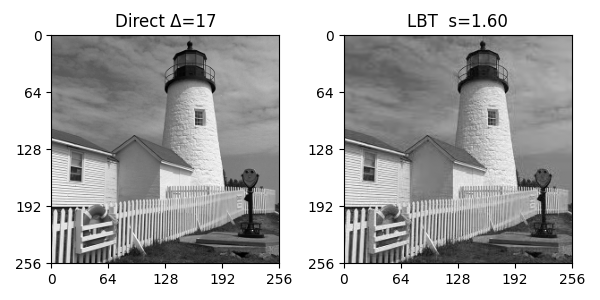

26.5467529296875 4.860687889341399


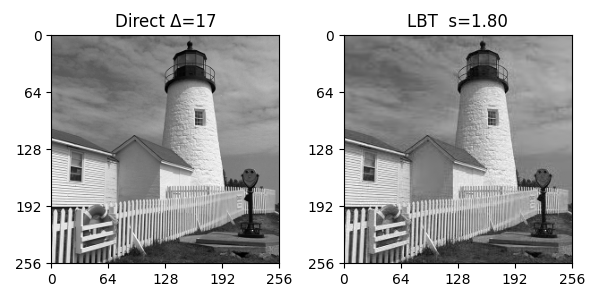

26.445068359375 4.861379870398401


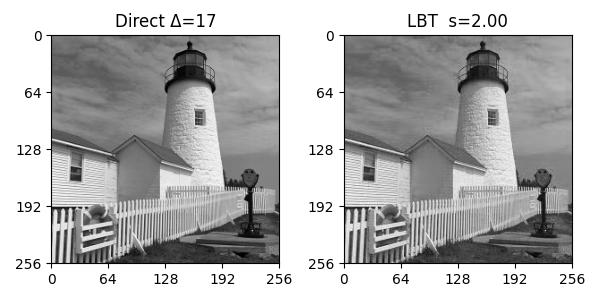

In [399]:
#Visual features
for s in (1.0, 1.2, 1.4, np.sqrt(2), 1.6, 1.8, 2.0):
    opt_step, opt_error = find_step_LBT(target_err=4.8612, s=s, N=8)
    print(opt_step, opt_error)
    Zp = lbt_reconstruct(X, N, s, opt_step)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))
    plot_image(X,  ax=ax1); ax1.set_title("Direct Δ=17")
    plot_image(Zp,  ax=ax2); ax2.set_title(f"LBT  s={s:3.2f}")
    plt.tight_layout(); plt.show()


The POT can often improve both compression and block smoothing, since the pre-filter
acts to reduce correlations between each DCT sub-block, whilst the inverse post-filter
acts to remove the discontinuities between sub-blocks. This is rather different from the
operation of the DCT. Investigate this by looking at the basis functions, as you did with
the DCT:

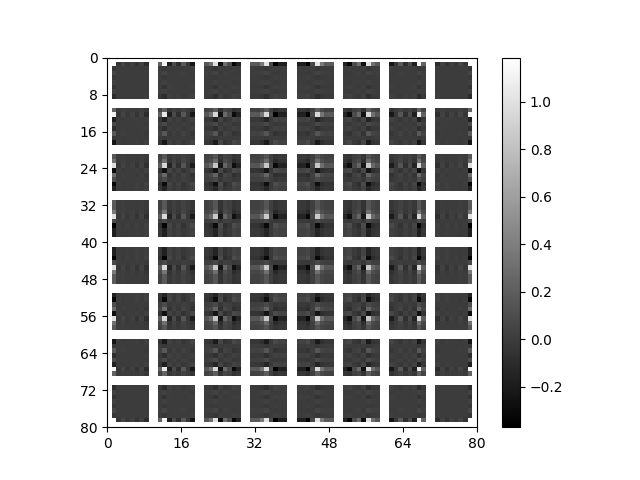

In [400]:
Pf, Pr = pot_ii(8)
bases = np.concatenate([np.full((8,1), np.nan), Pf, np.full((8,1), np.nan)], axis=1)
bases = bases.reshape(-1, 1)
fig, ax = plt.subplots()
im_obj = plot_image(bases @ bases.T, ax=ax)
fig.colorbar(im_obj, ax=ax);

<div class="alert alert-block alert-danger">

Look at both these bases and the pre-filtered image `Xp`, using different scaling factors
`s`, and comment on the visual effect of varying these scaling factors. You may need to
multiply `Xp` by up to 0.5 to display it better.</div>

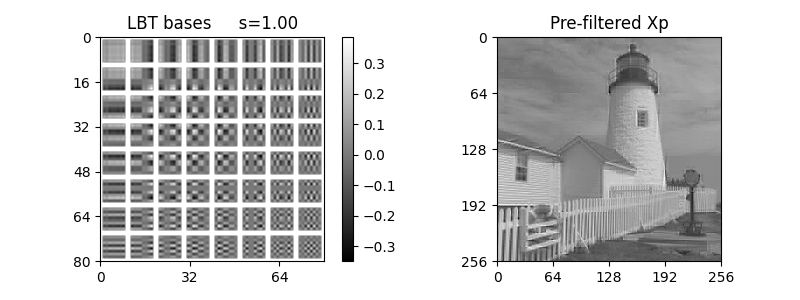

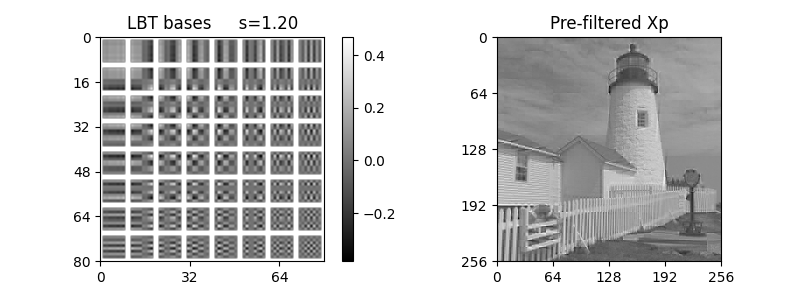

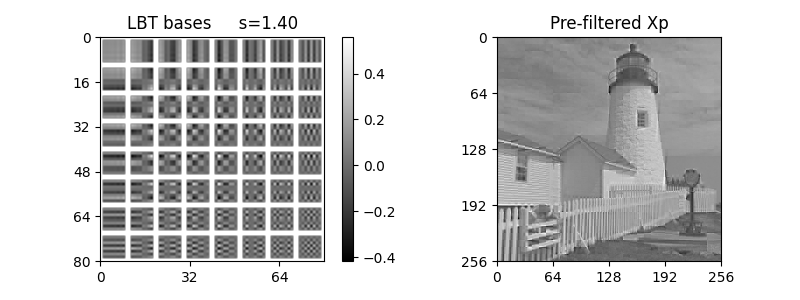

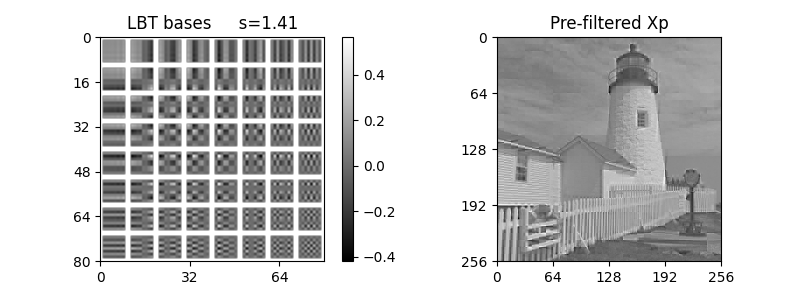

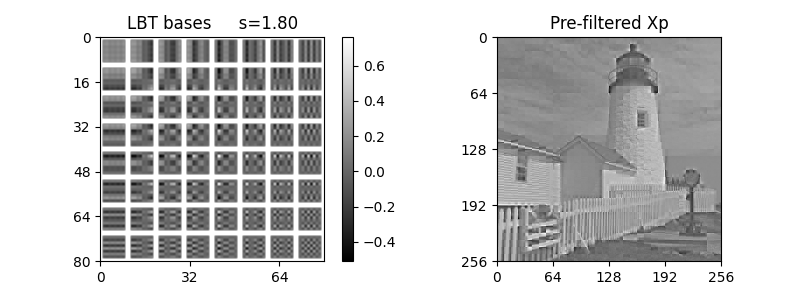

In [401]:
#Effect of different s on the pre-filtered image Xp and on the bases
# your code here
import numpy as np, matplotlib.pyplot as plt
from cued_sf2_lab.dct import dct_ii, colxfm
from cued_sf2_lab.lbt import pot_ii
from cued_sf2_lab.familiarisation import plot_image

# ---------- parameters -------------------------------------------------
N          = 8                 # block size
s_values   = [1.0, 1.2, 1.4, np.sqrt(2), 1.8]   # POT scale factors to compare
visual_gain= 0.5               # multiply Xp by this to enhance contrast

C  = dct_ii(N)                 # DCT for making the basis display
t  = np.s_[N//2:-N//2]         # slice for interior rows/cols

# ---------- loop over scale factors -----------------------------------
for s in s_values:
    # 1. POT matrices
    Pf, Pr = pot_ii(N, s)

    # 2. show the 64 LBT basis functions (Pf * C)
    bases = Pf @ C                        # 1-D basis
    bases = np.concatenate([np.full((8,1), np.nan), bases, np.full((8,1), np.nan)], axis=1)
    bases = bases.reshape(-1,1)      # turn into a column for plot_image()

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3))
    im = plot_image(bases @ bases.T, ax=ax1)
    ax1.set_title(f"LBT bases   s={s:3.2f}")
    fig.colorbar(im, ax=ax1)

    # 3. create the pre-filtered image Xp
    Xp = X.copy()
    Xp[t,:] = colxfm(Xp[t,:],  Pf)
    Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
    plot_image(Xp*0.5, ax=ax2)     # add 128 if X was zero-mean
    ax2.set_title("Pre-filtered Xp")

    plt.tight_layout(); plt.show()
  


With this type of POT / DCT combination it is common to use smaller DCT block sizes
but to code several blocks together. Hence a more accurate estimate of the number of bits
is found by always using 16 × 16 blocks, i.e. regroup `Yq` with the correct size `N` to give
`Yr`, but then always use `dctbpp(Yr, 16)`.

<div class="alert alert-block alert-danger">

Investigate the relative visual and compression performance of LBTs with 4 × 4, 8 × 8
and 16 × 16 blocks, using the scaling factor you have previously selected. As before, be
careful to match the rms error with a directly quantised image.</div>

In [402]:
# your code here 4*4
N = 4
for s in (1.0, 1.2, 1.4, np.sqrt(2), 1.6, 1.8, 2.0):

    # 1. find Δ* that gives rms_ref for this s
    Δ_star, _ = find_step_LBT(rms_ref, s=s, N=N)

    # 2. forward LBT ----------------------------------------------------
    t         = t_slice(N)
    Pf, Pr    = pot_ii(N, s)
    Xp        = X.copy()
    Xp[t, :]  = colxfm(Xp[t, :],  Pf)
    Xp[:, t]  = colxfm(Xp[:, t].T, Pf).T
    Y         = colxfm(colxfm(Xp.T, C).T, C)

    # 3. quantise and regroup ------------------------------------------
    Yq   = quantise(Y, Δ_star)
    Yr   = regroup(Yq, N) / N
    bits = dctbpp(Yr, 16)

    # 4. compression ratio ---------------------------------------------
    CR   = bits_ref / bits
    print(f"s={s:4.2f}  optimised_step={Δ_star:6.3f}  bits={bits:9,.0f}  CR={CR:5.3f}")



s=1.00  optimised_step=23.586  bits=   75,310  CR=3.029
s=1.20  optimised_step=26.553  bits=   73,518  CR=3.103
s=1.40  optimised_step=28.754  bits=   74,349  CR=3.068
s=1.41  optimised_step=28.862  bits=   74,524  CR=3.061
s=1.60  optimised_step=30.333  bits=   76,857  CR=2.968
s=1.80  optimised_step=30.943  bits=   81,330  CR=2.805
s=2.00  optimised_step=31.009  bits=   86,861  CR=2.626


In [403]:
# your code here 8*8
N = 8
for s in (1.0, 1.2, 1.4, np.sqrt(2), 1.6, 1.8, 2.0):

    # 1. find Δ* that gives rms_ref for this s
    Δ_star, _ = find_step_LBT(rms_ref, s=s, N=N)

    # 2. forward LBT ----------------------------------------------------
    t         = t_slice(N)
    Pf, Pr    = pot_ii(N, s)
    Xp        = X.copy()
    Xp[t, :]  = colxfm(Xp[t, :],  Pf)
    Xp[:, t]  = colxfm(Xp[:, t].T, Pf).T
    Y         = colxfm(colxfm(Xp.T, C).T, C)

    # 3. quantise and regroup ------------------------------------------
    Yq   = quantise(Y, Δ_star)
    Yr   = regroup(Yq, N) / N
    bits = dctbpp(Yr, 16)

    # 4. compression ratio ---------------------------------------------
    CR   = bits_ref / bits
    print(f"s={s:4.2f}  optimised_step={Δ_star:6.3f}  bits={bits:9,.0f}  CR={CR:5.3f}")



s=1.00  optimised_step=23.371  bits=   69,182  CR=3.297
s=1.20  optimised_step=24.854  bits=   66,994  CR=3.405
s=1.40  optimised_step=25.883  bits=   66,647  CR=3.423
s=1.41  optimised_step=25.955  bits=   66,634  CR=3.423
s=1.60  optimised_step=26.397  bits=   67,730  CR=3.368
s=1.80  optimised_step=26.547  bits=   70,111  CR=3.254
s=2.00  optimised_step=26.445  bits=   73,273  CR=3.113


In [404]:
# your code here 16*16
N = 16
for s in (1.0, 1.2, 1.4, np.sqrt(2), 1.6, 1.8, 2.0):

    # 1. find Δ* that gives rms_ref for this s
    Δ_star, _ = find_step_LBT(rms_ref, s=s, N=N)

    # 2. forward LBT ----------------------------------------------------
    t         = t_slice(N)
    Pf, Pr    = pot_ii(N, s)
    Xp        = X.copy()
    Xp[t, :]  = colxfm(Xp[t, :],  Pf)
    Xp[:, t]  = colxfm(Xp[:, t].T, Pf).T
    Y         = colxfm(colxfm(Xp.T, C).T, C)

    # 3. quantise and regroup ------------------------------------------
    Yq   = quantise(Y, Δ_star)
    Yr   = regroup(Yq, N) / N
    bits = dctbpp(Yr, 16)

    # 4. compression ratio ---------------------------------------------
    CR   = bits_ref / bits
    print(f"s={s:4.2f}  optimised_step={Δ_star:6.3f}  bits={bits:9,.0f}  CR={CR:5.3f}")



s=1.00  optimised_step=21.839  bits=   79,475  CR=2.870
s=1.20  optimised_step=22.521  bits=   79,016  CR=2.887
s=1.40  optimised_step=22.916  bits=   79,175  CR=2.881
s=1.41  optimised_step=22.940  bits=   79,217  CR=2.880
s=1.60  optimised_step=23.149  bits=   79,742  CR=2.861
s=1.80  optimised_step=23.263  bits=   80,780  CR=2.824
s=2.00  optimised_step=23.155  bits=   82,175  CR=2.776


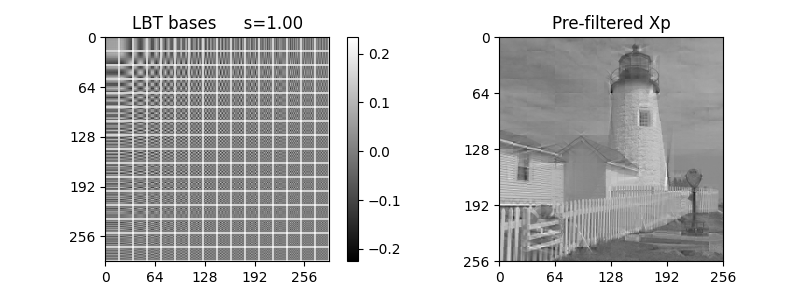

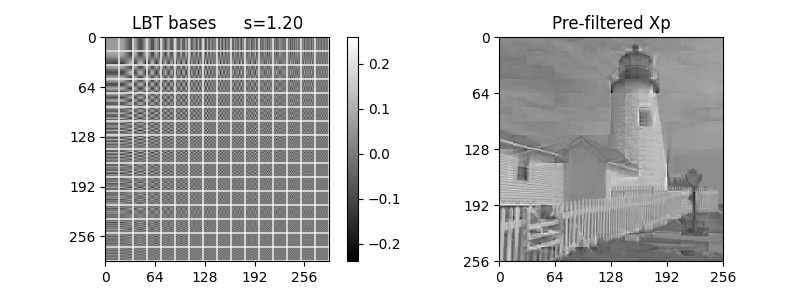

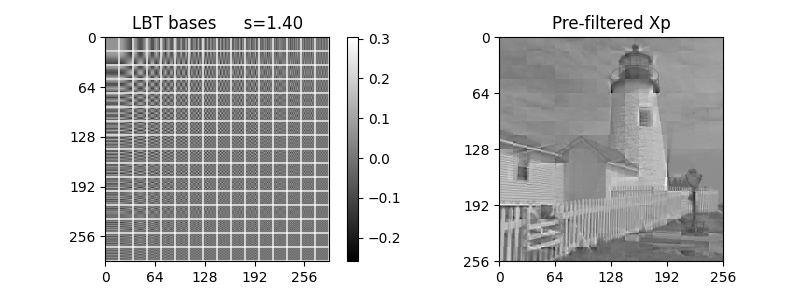

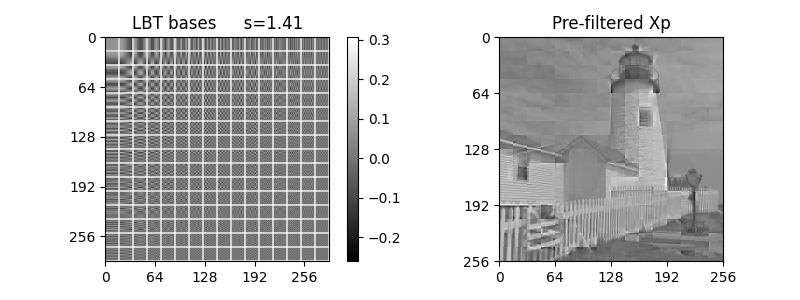

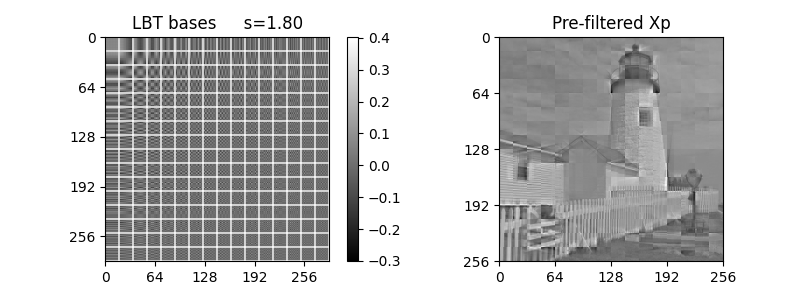

In [405]:
#Visual 
# your code here
import numpy as np, matplotlib.pyplot as plt
from cued_sf2_lab.dct import dct_ii, colxfm
from cued_sf2_lab.lbt import pot_ii
from cued_sf2_lab.familiarisation import plot_image

# ---------- parameters -------------------------------------------------
N          = 16                 # block size
s_values   = [1.0, 1.2, 1.4, np.sqrt(2), 1.8]   # POT scale factors to compare
visual_gain= 0.5               # multiply Xp by this to enhance contrast

C  = dct_ii(N)                 # DCT for making the basis display
t  = np.s_[N//2:-N//2]         # slice for interior rows/cols

# ---------- loop over scale factors -----------------------------------
for s in s_values:
    # 1. POT matrices
    Pf, Pr = pot_ii(N, s)

    # 2. show the 64 LBT basis functions (Pf * C)
    bases = Pf @ C                        # 1-D basis
    bases = np.concatenate([np.full((16,1), np.nan), bases, np.full((16,1), np.nan)], axis=1)
    bases = bases.reshape(-1,1)      # turn into a column for plot_image()

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3))
    im = plot_image(bases @ bases.T, ax=ax1)
    ax1.set_title(f"LBT bases   s={s:3.2f}")
    fig.colorbar(im, ax=ax1)

    # 3. create the pre-filtered image Xp
    Xp = X.copy()
    Xp[t,:] = colxfm(Xp[t,:],  Pf)
    Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
    plot_image(Xp*0.5, ax=ax2)     # add 128 if X was zero-mean
    ax2.set_title("Pre-filtered Xp")

    plt.tight_layout(); plt.show()
  
